## ***2 : DATA UNDERSTANDING***


### **2.1. Setup & Data Loading**

Before diving into the data, we need to import a number of Python libraries that will help us handle, manipulate, and analyze the dataset.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Surprise library for recommendation systems
from surprise import Dataset, Reader, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, NMF
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

# Set style for plots
sns.set_theme(style="whitegrid", palette="Set2")

#  inline plotting
%matplotlib inline

In [4]:
print("Loading  Datasets...\n")

movies  = pd.read_csv("../data/movies.csv")
ratings = pd.read_csv("../data/ratings.csv")
links   = pd.read_csv("../data/links.csv")
tags    = pd.read_csv("../data/tags.csv")

print(f"Movies: {len(movies)} records")
print(f"Ratings: {len(ratings)} records")
print(f"Links: {len(links)} records")
print(f"Tags: {len(tags)} records")


Loading  Datasets...

Movies: 9742 records
Ratings: 100836 records
Links: 9742 records
Tags: 3683 records


---
### **2.2 Initial Data Exploration**

Let's look at what our data contains.

In [6]:
# Movies dataset
print("Movies Dataset:")
print(f"Shape: {movies.shape}")
print(f"Columns: {movies.columns.tolist()}\n")
movies.head()

Movies Dataset:
Shape: (9742, 3)
Columns: ['movieId', 'title', 'genres']



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Ratings dataset
print("Ratings Dataset:")
print(f"Shape: {ratings.shape}")
print(f"Columns: {ratings.columns.tolist()}\n")
ratings.head()

Ratings Dataset:
Shape: (100836, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
# Tags dataset
print("Tags Dataset:")
print(f"Shape: {tags.shape}")
print(f"Columns: {tags.columns.tolist()}\n")
tags.head()

Tags Dataset:
Shape: (3683, 4)
Columns: ['userId', 'movieId', 'tag', 'timestamp']



,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
# Links dataset
print("Links Dataset:")
print(f"Shape: {links.shape}")
print(f"Columns: {links.columns.tolist()}\n")
links.head()


Links Dataset:
Shape: (9742, 3)
Columns: ['movieId', 'imdbId', 'tmdbId']



,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


---
### **2.3 Data Quality Check**

We check for missing values and duplicates to ensure clean data.

In [11]:
# Check for missing values
print("Missing Values:")
print(f"Movies: {movies.isnull().sum().sum()}")
print(f"Ratings: {ratings.isnull().sum().sum()}")
print(f"Tags: {tags.isnull().sum().sum()}")
print(f"Links: {links.isnull().sum().sum()}")


Missing Values:
Movies: 0
Ratings: 0
Tags: 0
Links: 8


In [12]:
# Check for duplicates
print("\nDuplicate Records:")
print(f"Movies: {movies.duplicated().sum()}")
print(f"Ratings: {ratings.duplicated(subset=['userId', 'movieId']).sum()}")
print(f"Tags: {tags.duplicated().sum()}")
print(f"Links: {links.duplicated().sum()}")



Duplicate Records:
Movies: 0
Ratings: 0
Tags: 0
Links: 0


---
### **2.4. Basic Statistics**

Understanding our data through key metrics.

In [14]:
# Rating statistics
print("Ratings Statistics:")
print(ratings['rating'].describe())

Ratings Statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [15]:
# User & Movie counts
print("\nUser & Movie Statistics:")
print(f"Unique Users: {ratings['userId'].nunique():,}")
print(f"Unique Movies: {ratings['movieId'].nunique():,}")


User & Movie Statistics:
Unique Users: 610
Unique Movies: 9,724


In [16]:
# Calculate sparsity
sparsity = (1 - len(ratings) / (ratings['userId'].nunique() * ratings['movieId'].nunique())) * 100
print(f"Sparsity: {sparsity:.2f}%")
print(f"\n💡 Sparsity shows that {sparsity:.1f}% of user-movie combinations have no rating.")

Sparsity: 98.30%

💡 Sparsity shows that 98.3% of user-movie combinations have no rating.




<span style="color:#ff6b6b; font-weight:bold;">
After the initial data exploration,
</span>
the dataset includes
<span style="color:#4dabf7; font-weight:bold;">
9,742 movies
</span>
and
<span style="color:#4dabf7; font-weight:bold;">
100,836 ratings
</span>
from
<span style="color:#4dabf7; font-weight:bold;">
610 users
</span>,
with a
<span style="color:#ffa726; font-weight:bold;">
sparsity of 98.3%.
</span>
The ratings are clean and range from
<span style="color:#53cbf1; font-weight:bold;">
0.5 to 5.0
</span>,
averaging
<span style="color:#53cbf1; font-weight:bold;">
3.5
</span>.
<span style="color:#ff6b6b; font-weight:bold;">
The high sparsity highlights the need for robust recommendation algorithms.
</span>

---

---
### **2.5. Data Integration**

The datasets will be combined into one unified DataFrame for analysis.

In [19]:
# Create unified dataset
# Merge ratings with movies
movie_data = ratings.merge(movies, on='movieId', how='left')

print(f"Unified dataset: {movie_data.shape}")

Unified dataset: (100836, 6)


In [20]:
# Verify data integrity
print(f"\n✓ Final dataset: {len(movie_data):,} rows")
print(f"✓ Original ratings: {len(ratings):,} rows")
print(f"✓ Data integrity: {'PASS ✓' if len(movie_data) == len(ratings) else 'FAIL ✗'}")


✓ Final dataset: 100,836 rows
✓ Original ratings: 100,836 rows
✓ Data integrity: PASS ✓


<span style="color:#ff6b6b; font-weight:bold;"> After integrating the ratings data, </span> the dataset combines <span style="color:#4dabf7; font-weight:bold;"> all 100,836 ratings </span> with <span style="color:#4dabf7; font-weight:bold;"> movie title and genre metadata </span> through a <span style="color:#ffa726; font-weight:bold;"> left join on movieId, </span> <span style="color:#ffa726; font-weight:bold;"> ensuring that every original rating is retained. </span> This integration <span style="color:#ffa726; font-weight:bold;"> supports data completeness, </span> while the inclusion of <span style="color:#53cbf1; font-weight:bold;"> descriptive movie attributes </span> <span style="color:#ff6b6b; font-weight:bold;"> enhances the dataset for recommendation analysis. </span>

In [22]:
# Display the unified dataset
print(f"Shape: {movie_data.shape}")
print(f"Columns: {movie_data.columns.tolist()}\n")
movie_data.head(10)

Shape: (100836, 6)
Columns: ['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres']



,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


---
### **2.6 Exploratory Data Analysis (EDA)**

Now we dive deep into understanding patterns in our data.

#### **2.6.1 User Activity Analysis**

How many movies do users typically rate?

User Activity Statistics:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

Most active user: User 414 with 2698 ratings
Least active user: User 53 with 20 ratings


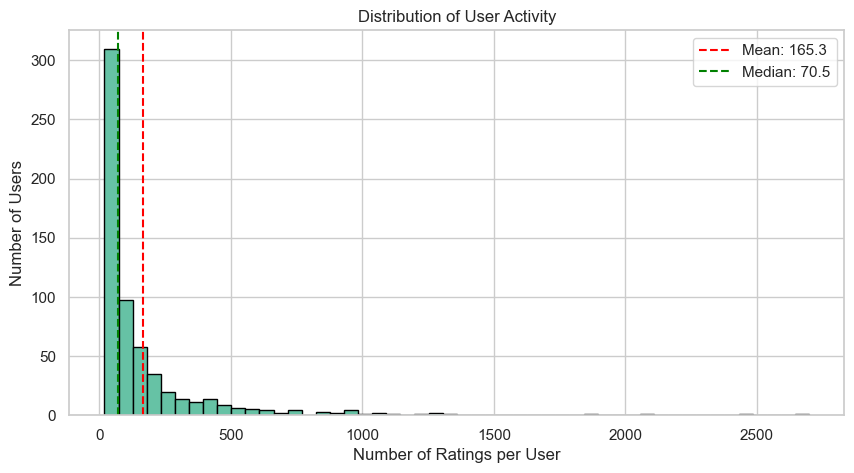

In [25]:
# Calculate ratings per user
user_ratings_count = movie_data.groupby('userId')['rating'].count()

# Summary statistics
print("User Activity Statistics:")
print(user_ratings_count.describe())
print(f"\nMost active user: User {user_ratings_count.idxmax()} with {user_ratings_count.max()} ratings")
print(f"Least active user: User {user_ratings_count.idxmin()} with {user_ratings_count.min()} ratings")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(user_ratings_count, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('Distribution of User Activity')
plt.axvline(user_ratings_count.mean(), color='red', linestyle='--', label=f'Mean: {user_ratings_count.mean():.1f}')
plt.axvline(user_ratings_count.median(), color='green', linestyle='--', label=f'Median: {user_ratings_count.median():.1f}')
plt.legend()
plt.show()

<span style="color:#ff6b6b; font-weight:bold;"> After analyzing user rating behavior, </span> the distribution reveals a <span style="color:#4dabf7; font-weight:bold;"> median of 70.5 ratings per user </span> compared to a <span style="color:#4dabf7; font-weight:bold;"> mean of 165.3, </span> <span style="color:#ffa726; font-weight:bold;"> indicating a highly skewed activity pattern. </span> While <span style="color:#ffa726; font-weight:bold;"> most users contribute ratings casually, </span> a small group of <span style="color:#53cbf1; font-weight:bold;"> power users (e.g., User 414 with 2,698 ratings) </span> <span style="color:#ff6b6b; font-weight:bold;"> accounts for a disproportionate share of the data. </span> Additionally, <span style="color:#ffa726; font-weight:bold;"> all users have rated at least 20 movies, </span> <span style="color:#ff6b6b; font-weight:bold;"> ensuring sufficient interaction density for collaborative filtering approaches. </span>

---
### **2.6.2 Movie Popularity Analysis**

Which movies get the most ratings?

Movie Popularity Statistics:
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

Most popular: 'Forrest Gump (1994)' with 329 ratings
Least popular: 'When Night Is Falling (1995)' with 1 rating(s)


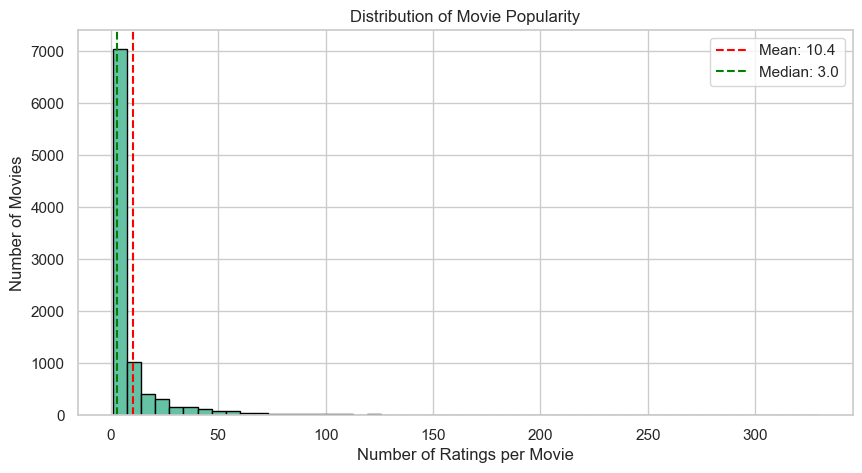

In [28]:
# Calculate ratings per movie
movie_ratings_count = movie_data.groupby('movieId')['rating'].count()

# Summary statistics
print("Movie Popularity Statistics:")
print(movie_ratings_count.describe())

# Find most and least popular movies
most_popular_id = movie_ratings_count.idxmax()
least_popular_id = movie_ratings_count.idxmin()

most_popular_title = movie_data[movie_data['movieId'] == most_popular_id]['title'].iloc[0]
least_popular_title = movie_data[movie_data['movieId'] == least_popular_id]['title'].iloc[0]

print(f"\nMost popular: '{most_popular_title}' with {movie_ratings_count.max()} ratings")
print(f"Least popular: '{least_popular_title}' with {movie_ratings_count.min()} rating(s)")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(movie_ratings_count, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Popularity')
plt.axvline(movie_ratings_count.mean(), color='red', linestyle='--', label=f'Mean: {movie_ratings_count.mean():.1f}')
plt.axvline(movie_ratings_count.median(), color='green', linestyle='--', label=f'Median: {movie_ratings_count.median():.1f}')
plt.legend()
plt.show()

<span style="color:#ff6b6b; font-weight:bold;"> After evaluating movie-level rating distributions, </span> the dataset exhibits a <span style="color:#4dabf7; font-weight:bold;"> median of only 3 ratings per movie </span> relative to a <span style="color:#4dabf7; font-weight:bold;"> mean of 10.4, </span> <span style="color:#ffa726; font-weight:bold;"> revealing an extremely skewed popularity pattern. </span> The most frequently rated title, <span style="color:#53cbf1; font-weight:bold;"> Forrest Gump (1994), </span> receives <span style="color:#4dabf7; font-weight:bold;"> 329 ratings, </span> while <span style="color:#ffa726; font-weight:bold;"> 75% of movies have nine or fewer ratings. </span> This <span style="color:#ffa726; font-weight:bold;"> pronounced long-tail distribution </span> <span style="color:#ff6b6b; font-weight:bold;"> introduces cold-start challenges for recommendation algorithms, </span> particularly for <span style="color:#53cbf1; font-weight:bold;"> the majority of movies with sparse rating histories. </span>

---
### **2.6.3. Genre Quality Analysis**

Which genres have the highest average ratings?

Total unique genres: 20
Total genre entries: 22084

Top 10 Most Common Genres:
genres
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


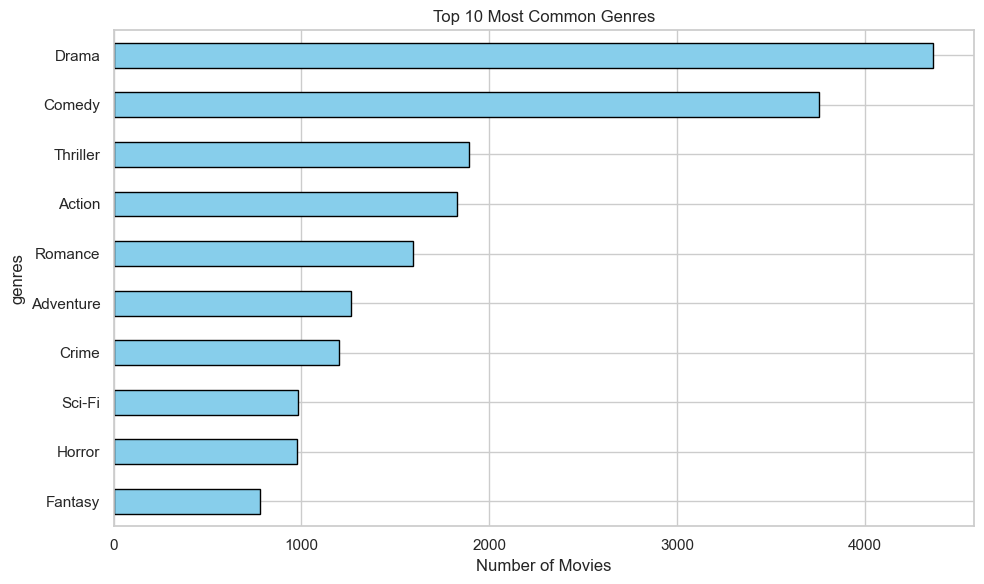

In [31]:
# Expand genres
genre_expanded = movies.assign(genres=movies['genres'].str.split('|')).explode('genres')
genre_counts = genre_expanded['genres'].value_counts()

print(f"Total unique genres: {len(genre_counts)}")
print(f"Total genre entries: {len(genre_expanded)}\n")

# Display top 10
print("Top 10 Most Common Genres:")
print(genre_counts.head(10))

# Visualize
plt.figure(figsize=(10, 6))
genre_counts.head(10).plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Number of Movies')
plt.title('Top 10 Most Common Genres')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


<span style="color:#ff6b6b; font-weight:bold;"> After analyzing genre composition, </span> the dataset comprises <span style="color:#4dabf7; font-weight:bold;"> 20 unique genres </span> across <span style="color:#4dabf7; font-weight:bold;"> 9,742 movies, </span> with an <span style="color:#4dabf7; font-weight:bold;"> average of 2.3 genres per film. </span> <span style="color:#53cbf1; font-weight:bold;"> Drama (4,361 movies) </span> and <span style="color:#53cbf1; font-weight:bold;"> Comedy (3,756 movies) </span> <span style="color:#ffa726; font-weight:bold;"> dominate the catalog, </span> together appearing in <span style="color:#4dabf7; font-weight:bold;"> over 80% of all films. </span> The <span style="color:#4dabf7; font-weight:bold;"> top 10 genres </span> account for <span style="color:#4dabf7; font-weight:bold;"> 84% of all genre tags, </span> <span style="color:#ffa726; font-weight:bold;"> indicating a concentration toward mainstream categories. </span> Despite the presence of <span style="color:#53cbf1; font-weight:bold;"> genre diversity, </span> the dataset remains <span style="color:#ff6b6b; font-weight:bold;"> heavily weighted toward narrative genres such as Drama, Comedy, Thriller, and Action. </span>

#### **2.6.1.1 Average Rating by Genre**

Genre Quality Rankings (min 100 ratings):

Rank  Genre                Avg Rating   # Ratings    Std Dev   
----------------------------------------------------------------------
1     Film-Noir            3.920        870          0.887     
2     War                  3.808        4859         0.979     
3     Documentary          3.798        1219         0.820     
4     Crime                3.658        16681        0.995     
5     Drama                3.656        41928        0.979     
6     Mystery              3.632        7674         1.006     
7     Animation            3.630        6988         0.970     
8     IMAX                 3.618        4145         0.988     
9     Western              3.584        1930         1.012     
10    Musical              3.564        4138         0.989     


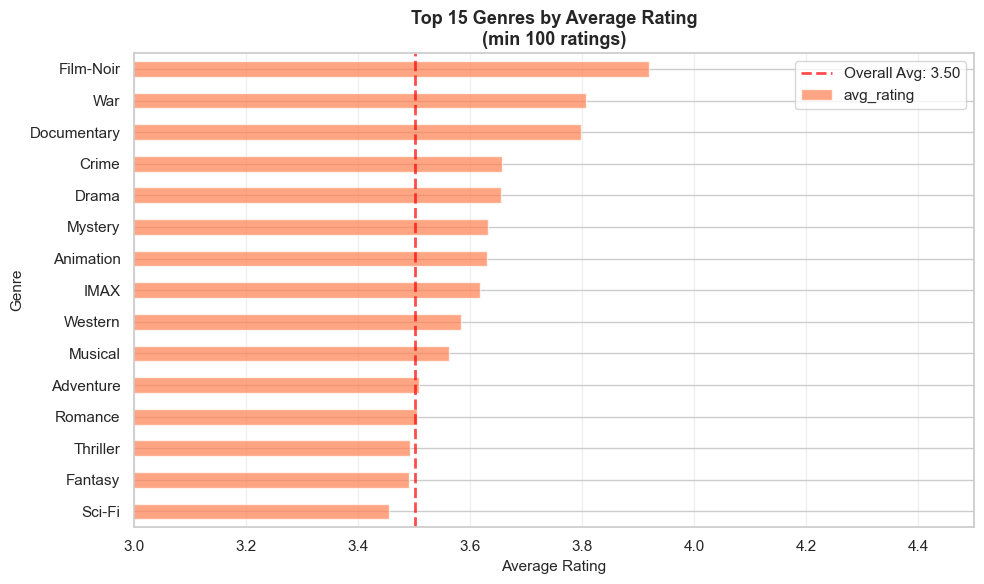

In [34]:

# Merge movie_data with genre information
movie_data_genre = movie_data.copy()
movie_data_genre['genres'] = movie_data_genre['genres'].str.split('|')
genre_ratings_expanded = movie_data_genre.explode('genres')

# Calculate average rating per genre
genre_stats = genre_ratings_expanded.groupby('genres').agg({
    'rating': ['mean', 'count', 'std']
}).reset_index()
genre_stats.columns = ['genre', 'avg_rating', 'num_ratings', 'std_rating']

# Filter genres with at least 100 ratings for reliability
genre_stats_filtered = genre_stats[genre_stats['num_ratings'] >= 100].copy()
genre_stats_filtered = genre_stats_filtered.sort_values('avg_rating', ascending=False)

print("Genre Quality Rankings (min 100 ratings):\n")
print(f"{'Rank':<5} {'Genre':<20} {'Avg Rating':<12} {'# Ratings':<12} {'Std Dev':<10}")
print("-" * 70)
for idx, row in enumerate(genre_stats_filtered.head(10).itertuples(), 1):
    print(f"{idx:<5} {row.genre:<20} {row.avg_rating:<12.3f} {row.num_ratings:<12} {row.std_rating:<10.3f}")

plt.figure(figsize=(10, 6))
genre_stats_filtered.head(15).set_index('genre')['avg_rating'].plot(
    kind='barh', color='coral', alpha=0.7
)
plt.title('Top 15 Genres by Average Rating\n(min 100 ratings)', 
          fontsize=13, fontweight='bold')
plt.xlabel('Average Rating', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.axvline(movie_data['rating'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f'Overall Avg: {movie_data["rating"].mean():.2f}')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.xlim(3.0, 4.5)
plt.tight_layout()
plt.show()

<span style="color:#ff6b6b; font-weight:bold;"> After evaluating genre-level rating quality, </span> the analysis shows that <span style="color:#53cbf1; font-weight:bold;"> niche genres such as Film-Noir (3.92), War (3.81), and Documentary (3.80) </span> <span style="color:#ffa726; font-weight:bold;"> achieve the highest average ratings despite lower popularity. </span> In contrast, <span style="color:#53cbf1; font-weight:bold;"> mainstream genres including Drama and Crime </span> maintain <span style="color:#4dabf7; font-weight:bold;"> solid above-average ratings (3.65+) </span> <span style="color:#ffa726; font-weight:bold;"> while attracting substantially higher rating volume. </span> The <span style="color:#4dabf7; font-weight:bold;"> standard deviation across genres (0.82–1.01) </span> <span style="color:#ffa726; font-weight:bold;"> remains relatively consistent, </span> <span style="color:#ff6b6b; font-weight:bold;"> indicating broad consensus in perceived film quality. </span> Together, these patterns <span style="color:#ffa726; font-weight:bold;"> suggest a “niche premium” effect, </span> where <span style="color:#53cbf1; font-weight:bold;"> specialized genres attract more engaged audiences who rate them more favorably. </span>

## **3: DATA PREPARATION**
 To prepare data for collaborative filtering, we extracted the core user-item interaction features (userId, movieId, rating) from the unified dataset. Quality checks confirmed:

- No missing values across all 100,836 records
- No duplicate user-movie rating pairs
- Valid rating range (0.5–5.0) consistent with MovieLens standards

 The final dataset includes 610 unique users and 9,724 unique movies, providing the necessary sparsity (98.3%) and scale for collaborative filtering approaches.

In [37]:
# Extract core features for collaborative filtering
print("\nExtracting core features (userId, movieId, rating)...")
ratings_df = movie_data[['userId', 'movieId', 'rating']].copy()

# Check for and remove any duplicates
duplicates_before = ratings_df.duplicated(subset=['userId', 'movieId']).sum()
print(f"   Duplicate user-movie pairs found: {duplicates_before}")

if duplicates_before > 0:
    ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId'], keep='first')
    print(f"   Duplicates removed, keeping first occurrence")

print(f"   Final ratings dataset: {len(ratings_df):,} records")

# Verify data quality
print("\n   Data Quality Checks:")
print(f"   ✓ Missing values: {ratings_df.isnull().sum().sum()}")
print(f"   ✓ Rating range: [{ratings_df['rating'].min()}, {ratings_df['rating'].max()}]")
print(f"   ✓ Unique users: {ratings_df['userId'].nunique():,}")
print(f"   ✓ Unique movies: {ratings_df['movieId'].nunique():,}")


Extracting core features (userId, movieId, rating)...
   Duplicate user-movie pairs found: 0
   Final ratings dataset: 100,836 records

   Data Quality Checks:
   ✓ Missing values: 0
   ✓ Rating range: [0.5, 5.0]
   ✓ Unique users: 610
   ✓ Unique movies: 9,724


### 3.2 Surprise Library Data Preparation
The dataset was prepared for Surprise-based collaborative filtering:

In [39]:
# Define the rating scale for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
print(f"   Rating scale configured: 0.5 to 5.0")

# Load the dataset into Surprise format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
print(f"   ✓ Dataset loaded into Surprise format")


   Rating scale configured: 0.5 to 5.0
   ✓ Dataset loaded into Surprise format


### *3.3 Train/Test Split*

An 80/20 train-test split was performed

In [41]:
# Train/test split (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training: {trainset.n_ratings:,} ratings | Testing: {len(testset):,} ratings")
print(f"Mean ratings - Train: {np.mean([r for (_, _, r) in trainset.all_ratings()]):.2f} | Test: {np.mean([r for (_, _, r) in testset]):.2f}")

Training: 80,668 ratings | Testing: 20,168 ratings
Mean ratings - Train: 3.50 | Test: 3.49


In [42]:
print(f"""
Data Preparation Complete:
   ✓ Total ratings: {len(ratings_df):,}
   ✓ Training: {trainset.n_ratings:,} ratings (80%) - {trainset.n_users:,} users, {trainset.n_items:,} movies
   ✓ Testing: {len(testset):,} ratings (20%)
   ✓ Split validated: Mean difference < 0.01
""")


Data Preparation Complete:
   ✓ Total ratings: 100,836
   ✓ Training: 80,668 ratings (80%) - 610 users, 8,928 movies
   ✓ Testing: 20,168 ratings (20%)
   ✓ Split validated: Mean difference < 0.01



## **4: MODELING**